In [1]:
# This is necessary to include the project directory into system paths
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Now we can import from project directory
from project.src.data_classes import (
    SCOTUS,
    Opinion
)

In [3]:
# Libraries for analysis, we want to abstract functionality into classes that can be imported above as we test/develop in Jupyter 
# This way, we work with classes (for Juypter use) and build out from there
# Try and build classes that encapsulates different constitute parts of the NLP
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.util import ngrams
import string
from nltk.corpus import stopwords
from itertools import combinations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

In [4]:
# usecols = ['author_name', 'category', 'per_curiam', 'case_name', 'year_filed', 'text']
# since_1970 = pd.read_csv('scotus/opinions_since_1970.csv', usecols=usecols)
# all_opinions = pd.read_csv('scotus/all_opinions.csv', usecols=usecols)
scotus_data = SCOTUS()
all_opinions = scotus_data.all_opinions.head()


In [5]:
# https://gist.github.com/emaadmanzoor/1d06e0751a3f7d39bc6814941b37531d
test_text = all_opinions.head().at[0, 'text']



In [6]:
# Counters for each justice encounter

class JusticeOpinionCounter:

    def __init__(self, author_name):
        self.texts = []
        self.unigram_counter = Counter()
        self.bigram_counter = Counter()
        self.trigram_counter = Counter()

    def add_opinion(self, text):
        self.texts.append(text)
     
        #         Clean and tokenize
        #         obvious-ly => obvious ly (lemmatization)
        words = ''.join((filter(lambda x: x in string.printable, text))).replace('\n', ' ')
        # print(type(words), len(words))
        words = words.replace('–', '')
        # print(type(words), len(words))
        table = str.maketrans('', '', string.punctuation+'’‘'+'“”'+'–'+string.digits+'­')
        words = [w.translate(table).lower() for w in words.split()]
        # print(type(words), len(words))
        stop_words = stopwords.words('english')
        words = list(filter(lambda w: w not in stop_words, words))
        # print(type(words), len(words))
        words = list(filter(lambda w: w.isalpha(), words))
        
        self.unigram_counter.update(list(ngrams(words, 1)))
        self.bigram_counter.update(list(ngrams(words, 2)))
        self.trigram_counter.update(list(ngrams(words, 3)))
        # print(len(words), len(self.unigram_counter.keys()), len(self.bigram_counter.keys()))

In [7]:
for x, op in all_opinions[['author_name', 'text']][0:10].iterrows():
    print()
    if (op['author_name'] == 'Justice Thomas'):
        print(op['text'])
        # print(len())



I adhere to the view that this Court’s decision in Buckley

v. Valeo, 424 U.S. 1 (1976) (per curiam), denigrates core
First Amendment speech and should be overruled. See
Randall v. Sorrell, 548 U.S. 230, 265–267 (2006)
(THOMAS, J., concurring in judgment); Federal Election
Comm’n v. Beaumont, 539 U.S. 146, 164–165 (2003)
(THOMAS, J., dissenting); Federal Election Comm’n v.
Colorado Republican Federal Campaign Comm., 533 U.S.
431, 465–466 (2001) (Colorado II) (THOMAS, J., dissent-
ing); Nixon v. Shrink Missouri Government PAC, 528 U.S.
377, 412–420 (2000) (THOMAS, J., dissenting); Colorado
Republican Federal Campaign Comm. v. Federal Election
Comm’n, 518 U.S. 604, 635–640 (1996) (Colorado I )
(THOMAS, J., concurring in judgment and dissenting in
part).
   Political speech is “ ‘the primary object of First Amend-
ment protection’ ” and “the lifeblood of a self-governing
people.” Colorado II, supra, at 465–466 (THOMAS, J.,
dissenting). Contributions to political campaigns, no less
than 

In [8]:
def opinion_counter(df):
    op_counters = {}
    for i, op in df[['author_name', 'text']][:1000].iterrows():
        author_name = op['author_name']
        if author_name not in op_counters:
            op_counters[author_name] = JusticeOpinionCounter(author_name)
        op_counters[author_name].add_opinion(op['text'])
    return op_counters

In [9]:
%%time
op_counters = opinion_counter(all_opinions)
len(all_opinions)

CPU times: user 112 ms, sys: 3 µs, total: 112 ms
Wall time: 113 ms


5

In [10]:
op_counters

{'Justice Roberts': <__main__.JusticeOpinionCounter at 0x7f44565aacd0>,
 'Justice Thomas': <__main__.JusticeOpinionCounter at 0x7f445911d070>,
 'Justice Breyer': <__main__.JusticeOpinionCounter at 0x7f4457b4e340>,
 'Justice Taney': <__main__.JusticeOpinionCounter at 0x7f4457a75e20>,
 'Justice Pitney': <__main__.JusticeOpinionCounter at 0x7f4457a75dc0>}

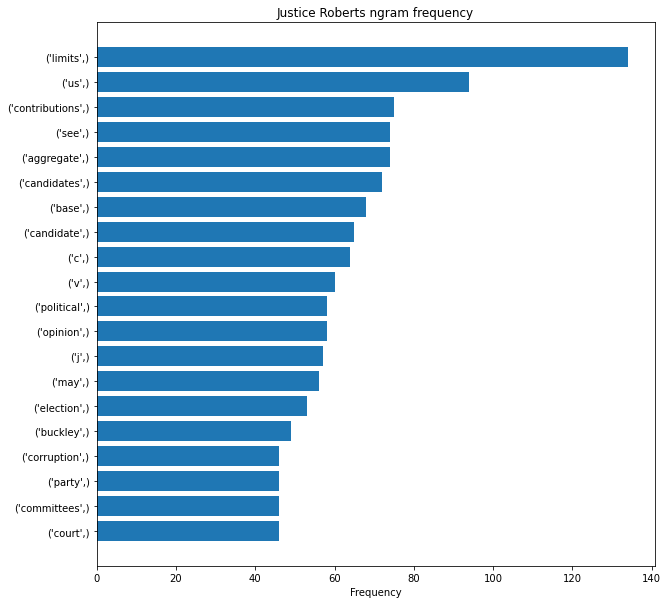

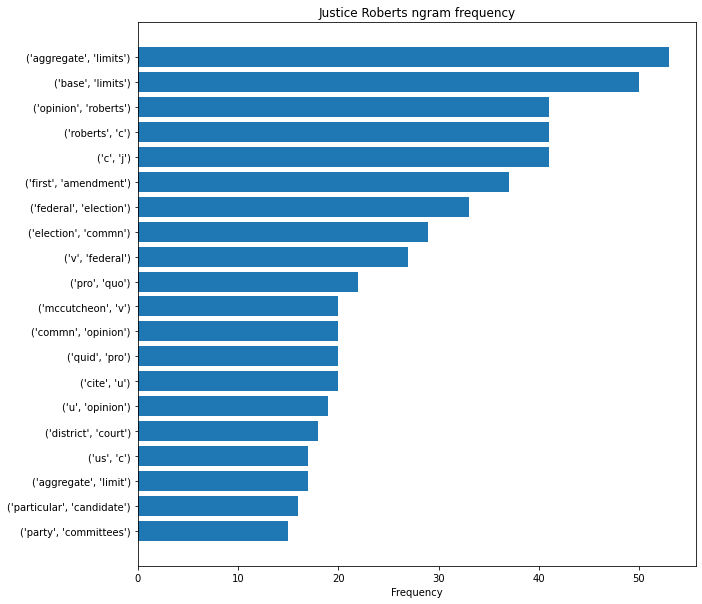

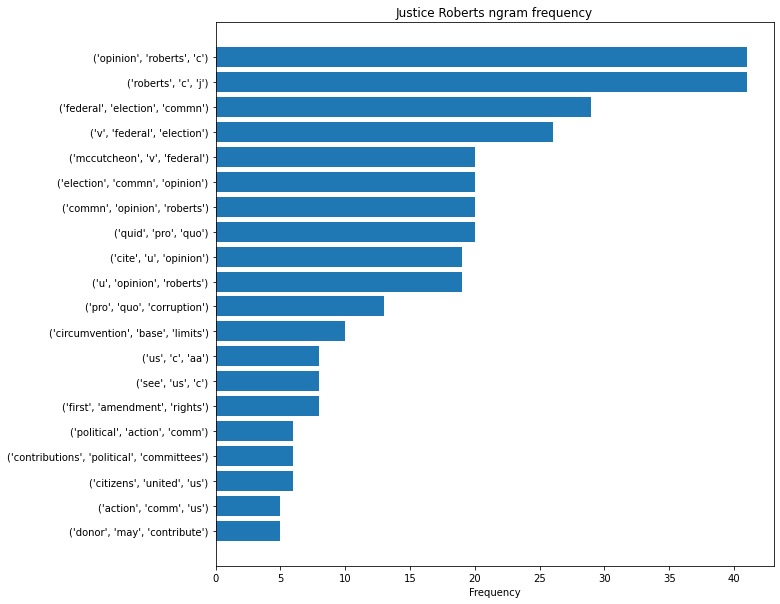

In [11]:
def ngram_barchart(most_common, author_name):
    fig, ax = plt.subplots()
    # Example data
    tokens = list(map(lambda token_freq: token_freq[0], most_common))
    y_pos = np.arange(len(tokens))
    freqs = list(map(lambda token_freq: token_freq[1], most_common))
    
    ax.barh(y_pos, freqs, align='center')
    ax.set_yticks(y_pos, labels=tokens)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title(f'{author_name} ngram frequency')
    plt.show()
    
def most_common_barchart(op_counters, author_name, top=20):
    most_common_uni = op_counters[author_name].unigram_counter.most_common()[:top]
    most_common_bi = op_counters[author_name].bigram_counter.most_common()[:top]
    most_common_tri = op_counters[author_name].trigram_counter.most_common()[:top]
    ngram_barchart(most_common_uni, author_name)
    ngram_barchart(most_common_bi, author_name)
    ngram_barchart(most_common_tri, author_name)
    
    
most_common_barchart(op_counters, 'Justice Roberts')

In [12]:
def print_most_common(op_counters, author_name, top=10):
    min_token_len = lambda w: len(w) >= 1
    counter = op_counters[author_name]
    print(author_name)
    print('\t unigrams:')
    [print(f'\t\t{k} {v}') for k,v in counter.unigram_counter.most_common(top)]
    print('\t bigrams:')
    [print(f'\t\t{k} {v}') for k,v in counter.bigram_counter.most_common(top) if all(map(min_token_len, k))]
    print('\t trigrams:')
    [print(f'\t\t{k} {v}') for k,v in counter.trigram_counter.most_common(top) if all(map(min_token_len, k))]
    
print_most_common(op_counters, 'Justice Roberts')

Justice Roberts
	 unigrams:
		('limits',) 134
		('us',) 94
		('contributions',) 75
		('see',) 74
		('aggregate',) 74
		('candidates',) 72
		('base',) 68
		('candidate',) 65
		('c',) 64
		('v',) 60
	 bigrams:
		('aggregate', 'limits') 53
		('base', 'limits') 50
		('opinion', 'roberts') 41
		('roberts', 'c') 41
		('c', 'j') 41
		('first', 'amendment') 37
		('federal', 'election') 33
		('election', 'commn') 29
		('v', 'federal') 27
		('pro', 'quo') 22
	 trigrams:
		('opinion', 'roberts', 'c') 41
		('roberts', 'c', 'j') 41
		('federal', 'election', 'commn') 29
		('v', 'federal', 'election') 26
		('mccutcheon', 'v', 'federal') 20
		('election', 'commn', 'opinion') 20
		('commn', 'opinion', 'roberts') 20
		('quid', 'pro', 'quo') 20
		('cite', 'u', 'opinion') 19
		('u', 'opinion', 'roberts') 19


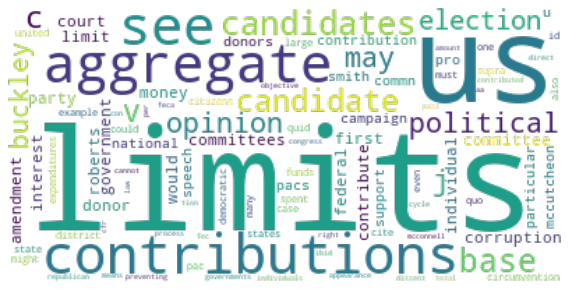

In [13]:
# for x, op in all_opinions[['author_name', 'text']][0:10].iterrows():
#     print()
#     if (op['author_name'] == 'Justice Thomas'):
#         print(op['text'])
#         # print(len())

def unigram_wordcloud(op_counters, author_name):
    wordcloud_unigrams = dict([[k[0],v] for k,v in op_counters[author_name].unigram_counter.items()])
    wordcloud = WordCloud(background_color=None, mode='RGBA', max_words=100).generate_from_frequencies(wordcloud_unigrams)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
unigram_wordcloud(op_counters, 'Justice Roberts')

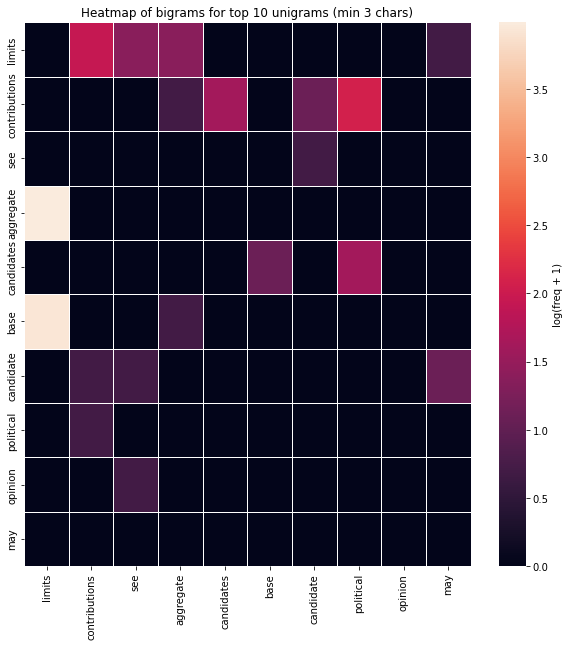

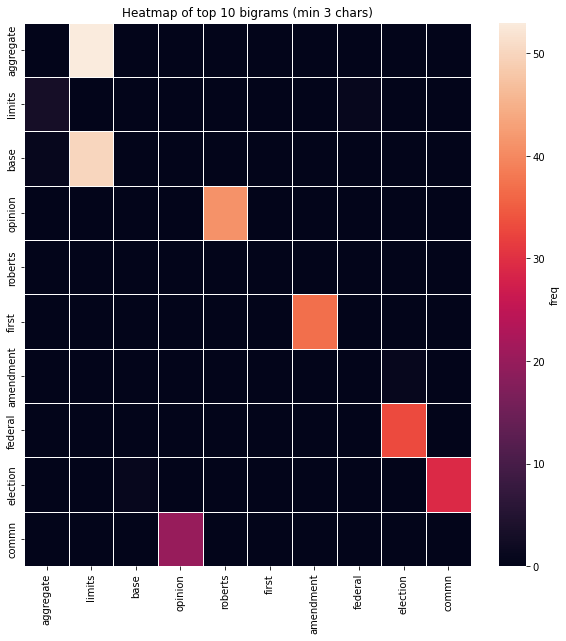

array([[ 0, 53,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 1, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 41,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 37,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 33,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0, 29],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0]])

In [14]:
def most_common_unigram_heatmap(op_counters, author_name, top=10):
    min_token_len = 3
    most_common = op_counters[author_name].unigram_counter.most_common()
    top_unigrams = [k[0] for k, v in most_common if len(k[0]) >= min_token_len][:top]
    i2t = dict([[k,v] for k,v in enumerate(top_unigrams)])
    heatmap_bigram = np.zeros((top,top), int)
    for i in range(top):
        for j in range(top):
            heatmap_bigram[i,j] = op_counters[author_name].bigram_counter[(i2t[i], i2t[j])]
    heatmap_bigram = np.log(heatmap_bigram + 1)
    ax = sns.heatmap(heatmap_bigram, linewidth=0.5,  xticklabels=top_unigrams, yticklabels=top_unigrams, cbar_kws={'label': 'log(freq + 1)'})
    plt.title(f'Heatmap of bigrams for top {top} unigrams (min {min_token_len} chars)')
    plt.show()
    return heatmap_bigram
            
def most_common_bigram_heatmap(op_counters, author_name, top=10):
    min_token_len = 3
    most_common = op_counters[author_name].bigram_counter.most_common()
    tokens = []
    for bigram, freq in most_common:
        for token in bigram:
            if token not in tokens and len(token) >= min_token_len:
                tokens.append(token)
    top_tokens = tokens[:top]
    
    i2t = dict([[k,v] for k,v in enumerate(top_tokens)])
    heatmap_bigram = np.zeros((top,top), int)
    for i in range(top):
        for j in range(top):
            heatmap_bigram[i,j] = op_counters[author_name].bigram_counter[(i2t[i], i2t[j])]
    # heatmap_bigram = np.log(heatmap_bigram + 1)
    ax = sns.heatmap(heatmap_bigram, linewidth=0.5, xticklabels=top_tokens, yticklabels=top_tokens, cbar_kws={'label': 'freq'})
    plt.title(f'Heatmap of top {top} bigrams (min {min_token_len} chars)')
    plt.show()
    return heatmap_bigram

most_common_unigram_heatmap(op_counters, 'Justice Roberts')
most_common_bigram_heatmap(op_counters, 'Justice Roberts')





Justice Pitney
	 unigrams:
		('property',) 34
		('tunnel',) 28
		('private',) 24
		('upon',) 23
		('railroad',) 17
		('public',) 17
		('tracks',) 16
		('v',) 15
		('smoke',) 14
		('without',) 13
	 bigrams:
		('gases', 'smoke') 9
		('private', 'property') 8
		('public', 'use') 7
		('without', 'compensation') 7
		('south', 'portal') 6
		('tunnel', 'tracks') 6
		('plaintiffs', 'property') 6
		('acts', 'congress') 6
		('locomotive', 'engines') 6
		('operation', 'railroad') 5
	 trigrams:
		('gases', 'smoke', 'emitted') 5
		('public', 'use', 'without') 5
		('use', 'without', 'compensation') 5
		('taking', 'private', 'property') 4
		('private', 'property', 'public') 4
		('property', 'public', 'use') 4
		('engines', 'tunnel', 'forced') 3
		('damage', 'attributable', 'gases') 3
		('attributable', 'gases', 'smoke') 3
		('smoke', 'emitted', 'locomotive') 3


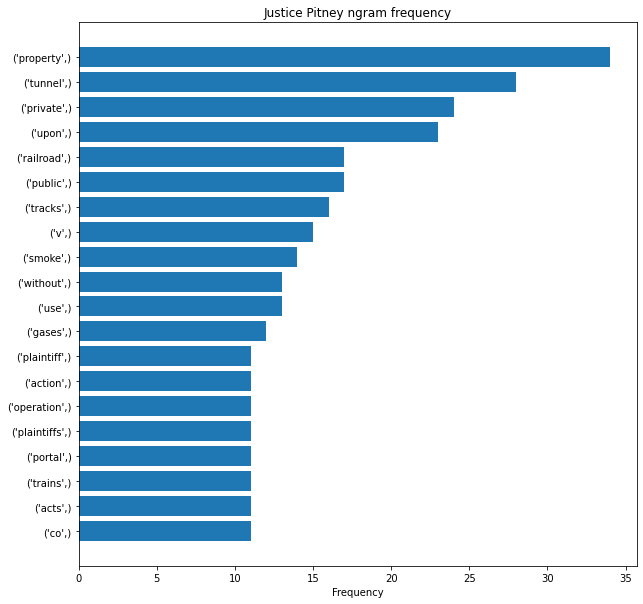

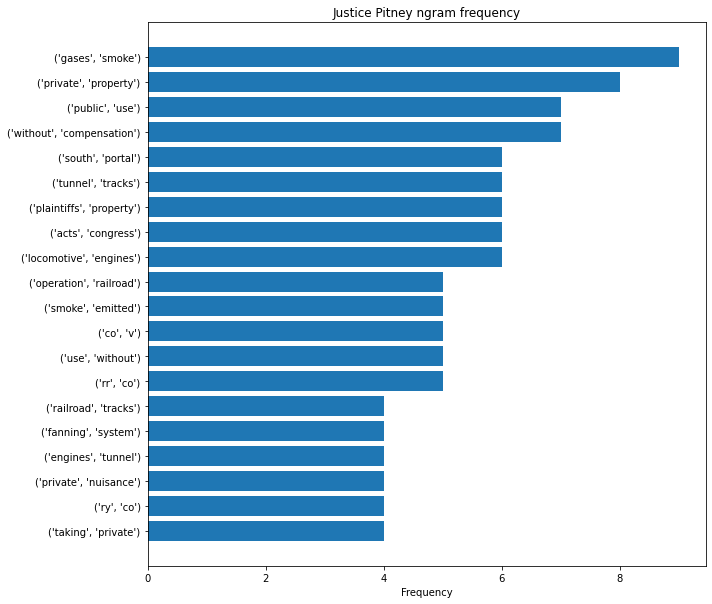

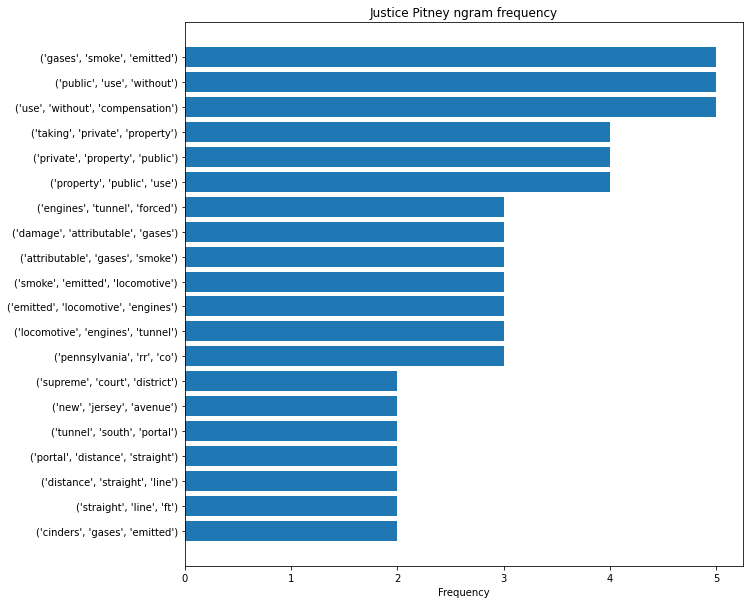

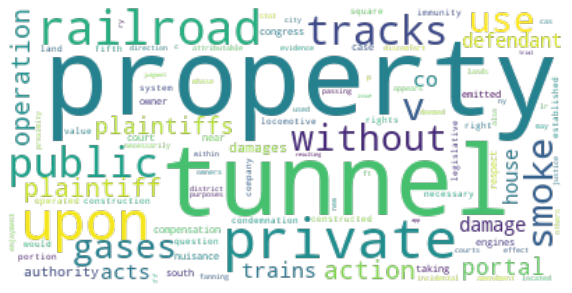

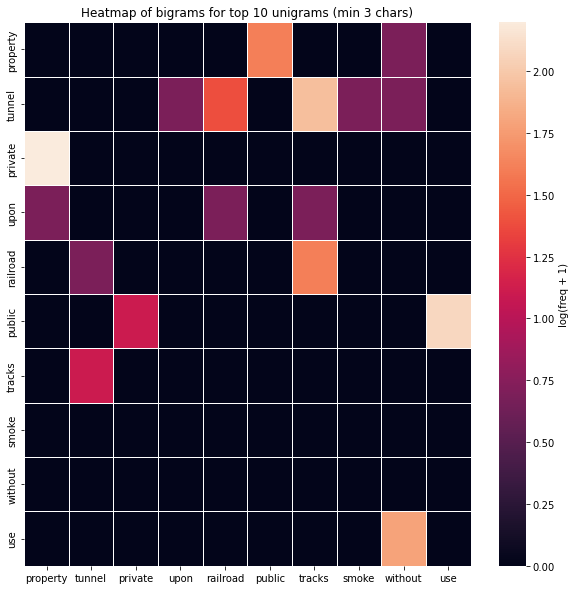

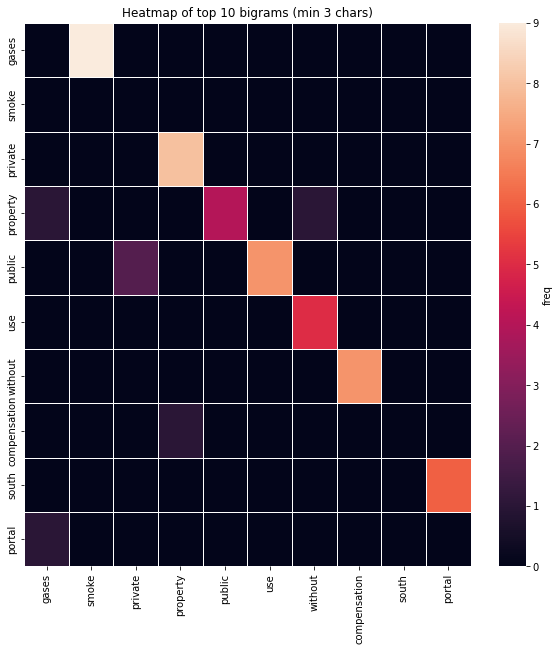

In [15]:
def summarize(op_counters, author_name):
    print_most_common(op_counters, author_name)
    most_common_barchart(op_counters, author_name)
    unigram_wordcloud(op_counters, author_name)
    most_common_unigram_heatmap(op_counters, author_name)
    most_common_bigram_heatmap(op_counters, author_name)
summarize(op_counters, 'Justice Pitney')

In [16]:
def print_justices(df):
    justices = list(set(df['author_name']))
    print(f'{len(justices)} opinion authors')
    # [print(f'\t{j}') for j in justices]6
    return justices

def print_cases(df):
    cases = list(set(df['case_name']))
    print(f'{len(cases)} cases')
    # [print(f'\t{c}') for c in cases]
    return cases

def select_opinions_df(df, author_names=None, case_names=None):
    # Filter opinions that are not 'per_curiam' (by the court)
    opinions = df[df['per_curiam'] == False]
    if author_names is not None:
        opinions = opinions.loc[opinions['author_name'].isin(author_names)]
    if case_names is not None:
        opinions = opinions.loc[opinions['case_name'].isin(case_names)]
    
    cases = print_cases(opinions)
    justices = print_justices(opinions)
    return cases, justices, opinions

In [17]:
# https://en.wikipedia.org/wiki/List_of_landmark_court_decisions_in_the_United_States#Birth_control_and_abortion
landmark_cases = [
    "Griswold v. Connecticut",
    "Eisenstadt v. Baird",
    "Roe v. Wade",
    "Carey v. Population Services International",
    "Planned Parenthood v. Casey",
    "Stenberg v. Carhart",
    "Gonzales v. Carhart",
    "Burwell v. Hobby Lobby Stores, Inc.",
    "Whole Woman's Health v. Hellerstedt"
]
author_names = None
# cases = print_cases(all_opinions)
# for case_name in landmark_cases:
    # print(f'{case_name} available: {case_name in cases}') 
cases, justices, opinions = select_opinions_df(all_opinions, author_names=author_names, case_names=landmark_cases)
landmark_counter = opinion_counter(opinions)
for j in justices:
    summarize(landmark_counter, j)

0 cases
0 opinion authors


In [18]:
print_cases(all_opinions.loc[all_opinions['year_filed'].isin([1977, 1976, 1978])])

0 cases


[]

Justices appointed by party: (Democratic, Republican)
Category of opinion: (Dissenting , Concurring, Majority)

For each case:
    determine which 'party' had majority justices for a decision
    According to asym poli: there should be less agreement across parties as time goes on
        Polarization => Asymmetric polarization (levels of analysis)
            If it polarizes, is it asymmetric?
        For different presidential terms (political mood): split cases by presidential term and evaluate stats
    Do certain decisions/categories occur for certain presidential party?
    
    

Two dimensions of analysis: across time (for landmark cases) and within decisions (across categories)

For within decisions: how do words cluster?

For across time: alignment of word embeddings